# FAISS Example 02: IVF Clustering Visualization
# Ví dụ 2: Trực quan hóa IVF Clustering

Notebook này minh họa:
- Cách IVF (Inverted File) hoạt động
- Visualization của clusters và centroids
- Trade-off giữa nprobe và accuracy/speed
- So sánh IVF với Flat index

In [8]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.data_generator import generate_random_vectors, generate_query_vectors
from utils.benchmark import benchmark_index, calculate_recall, progressive_recall_benchmark
from utils.visualization import plot_recall_vs_time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports hoàn tất!")

✓ Imports hoàn tất!


## 1. Tạo dữ liệu

In [9]:
# Configuration
dimension = 128
n_vectors = 50000
n_queries = 200
k = 10

print(f"Cấu hình:")
print(f"  Dimension: {dimension}")
print(f"  Database size: {n_vectors:,}")
print(f"  Queries: {n_queries}")
print(f"  k: {k}")

# Generate
np.random.seed(42)
database_vectors = generate_random_vectors(n_vectors, dimension)
query_vectors = generate_query_vectors(n_queries, dimension)

print(f"\n✓ Data ready: {database_vectors.shape}")

Cấu hình:
  Dimension: 128
  Database size: 50,000
  Queries: 200
  k: 10

✓ Data ready: (50000, 128)


## 2. Tạo Ground Truth (Flat Index)

In [10]:
# Build Flat index for ground truth
print("Tạo Flat index cho ground truth...")
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(database_vectors)

# Get ground truth
gt_distances, gt_indices = index_flat.search(query_vectors, k)
print(f"✓ Ground truth ready")

Tạo Flat index cho ground truth...
✓ Ground truth ready


## 3. Xây dựng IVF Index

In [11]:
# IVF parameters
nlist = int(np.sqrt(n_vectors))  # Rule of thumb
nprobe = 10

print(f"IVF parameters:")
print(f"  nlist (clusters): {nlist}")
print(f"  nprobe (search): {nprobe}")
print(f"  Avg vectors per cluster: {n_vectors/nlist:.0f}")

# Build IVF
print(f"\nTraining IVF...")
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)

start = time.time()
index_ivf.train(database_vectors)
train_time = time.time() - start

start = time.time()
index_ivf.add(database_vectors)
add_time = time.time() - start

index_ivf.nprobe = nprobe

print(f"✓ Train time: {train_time:.3f}s")
print(f"✓ Add time: {add_time:.3f}s")
print(f"✓ Total build time: {train_time + add_time:.3f}s")

IVF parameters:
  nlist (clusters): 223
  nprobe (search): 10
  Avg vectors per cluster: 224

Training IVF...
✓ Train time: 0.781s
✓ Add time: 0.073s
✓ Total build time: 0.854s


## 4. Visualization - Cluster Distribution

Phân tích phân bố clusters...

Cluster statistics:
  Total clusters: 223
  Min cluster size: 2
  Max cluster size: 285
  Mean cluster size: 224.2
  Std cluster size: 27.1


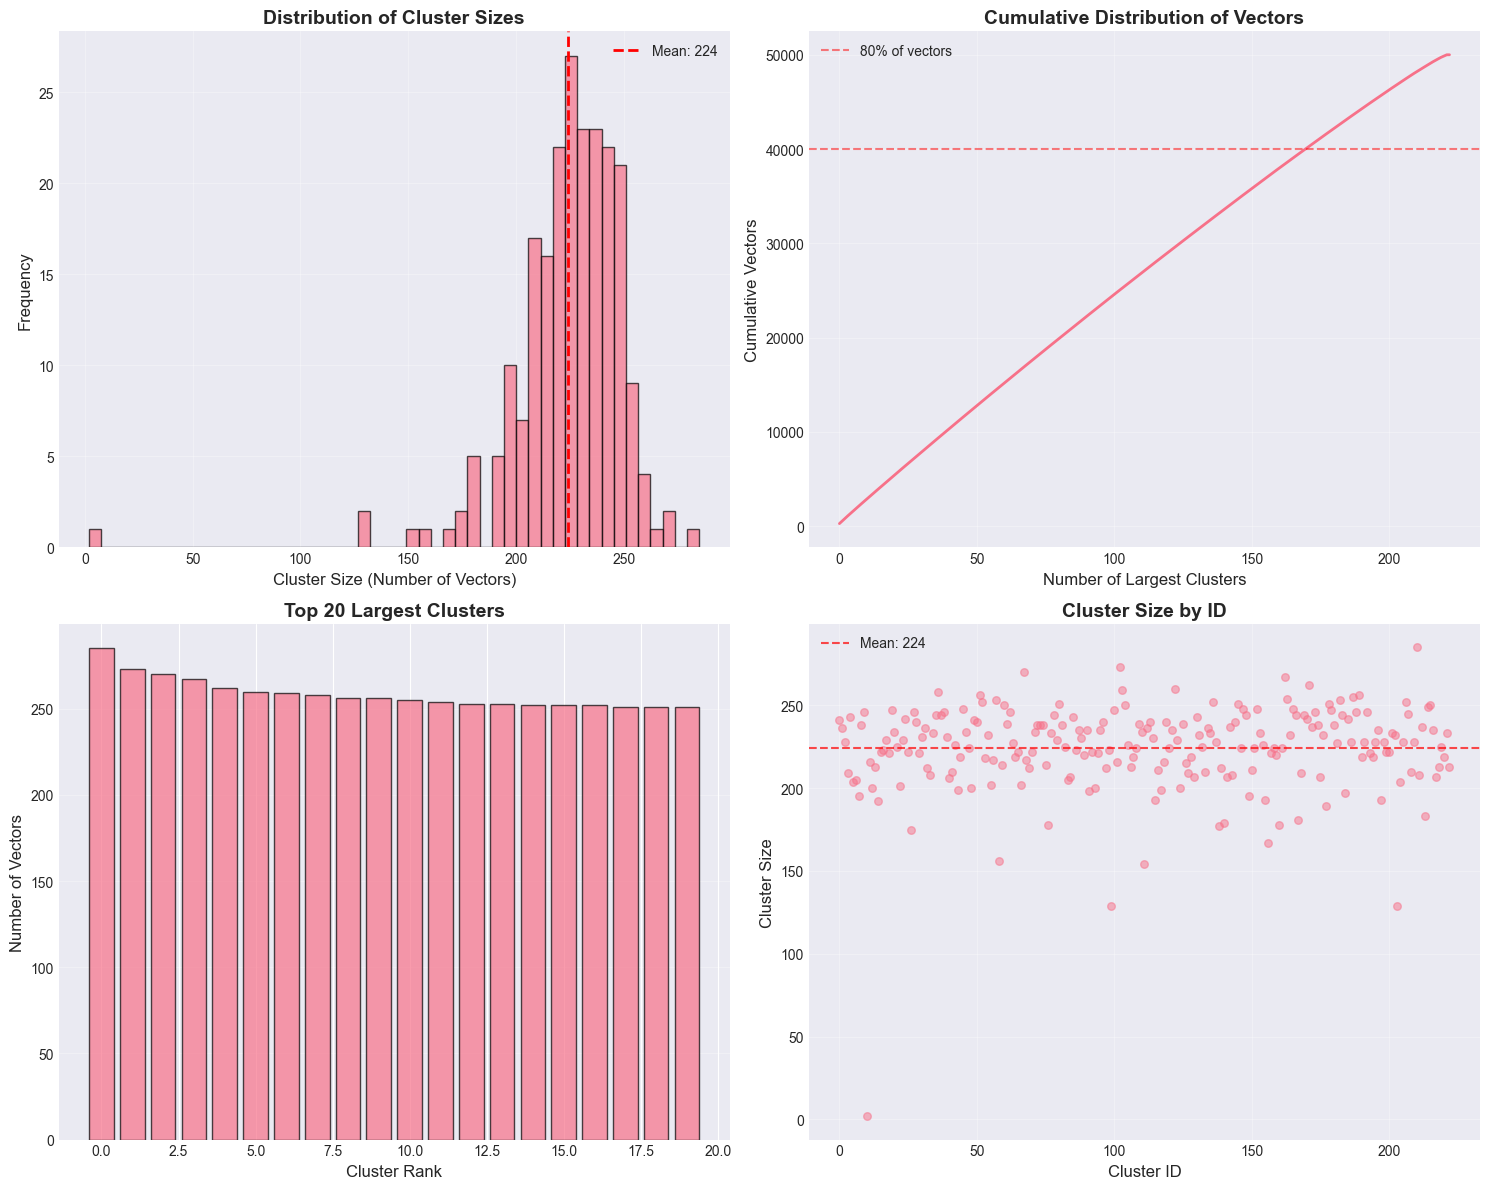


✓ Đã lưu: 02_cluster_distribution.png


In [12]:
# Analyze cluster distribution
print("Phân tích phân bố clusters...\n")

# Get cluster assignments for all vectors
_, cluster_assignments = quantizer.search(database_vectors, 1)
cluster_assignments = cluster_assignments.flatten()

# Count vectors per cluster
unique_clusters, cluster_sizes = np.unique(cluster_assignments, return_counts=True)

print(f"Cluster statistics:")
print(f"  Total clusters: {len(unique_clusters)}")
print(f"  Min cluster size: {cluster_sizes.min()}")
print(f"  Max cluster size: {cluster_sizes.max()}")
print(f"  Mean cluster size: {cluster_sizes.mean():.1f}")
print(f"  Std cluster size: {cluster_sizes.std():.1f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cluster size distribution
ax = axes[0, 0]
ax.hist(cluster_sizes, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(cluster_sizes.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {cluster_sizes.mean():.0f}')
ax.set_xlabel('Cluster Size (Number of Vectors)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Cluster Sizes', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Cumulative distribution
ax = axes[0, 1]
sorted_sizes = np.sort(cluster_sizes)[::-1]
cumsum = np.cumsum(sorted_sizes)
ax.plot(cumsum, linewidth=2)
ax.axhline(n_vectors * 0.8, color='red', linestyle='--', 
           alpha=0.5, label='80% of vectors')
ax.set_xlabel('Number of Largest Clusters', fontsize=12)
ax.set_ylabel('Cumulative Vectors', fontsize=12)
ax.set_title('Cumulative Distribution of Vectors', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Top 20 largest clusters
ax = axes[1, 0]
top_20_idx = np.argsort(cluster_sizes)[-20:][::-1]
top_20_sizes = cluster_sizes[top_20_idx]
ax.bar(range(20), top_20_sizes, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cluster Rank', fontsize=12)
ax.set_ylabel('Number of Vectors', fontsize=12)
ax.set_title('Top 20 Largest Clusters', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Cluster size vs cluster ID
ax = axes[1, 1]
ax.scatter(unique_clusters, cluster_sizes, alpha=0.5, s=30)
ax.axhline(cluster_sizes.mean(), color='red', linestyle='--', 
           alpha=0.7, label=f'Mean: {cluster_sizes.mean():.0f}')
ax.set_xlabel('Cluster ID', fontsize=12)
ax.set_ylabel('Cluster Size', fontsize=12)
ax.set_title('Cluster Size by ID', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Đã lưu: 02_cluster_distribution.png")

## 5. Visualization - 2D Projection của Clusters

Visualization clusters trong 2D...
  Applying PCA...
  ✓ PCA explained variance: 2.36%


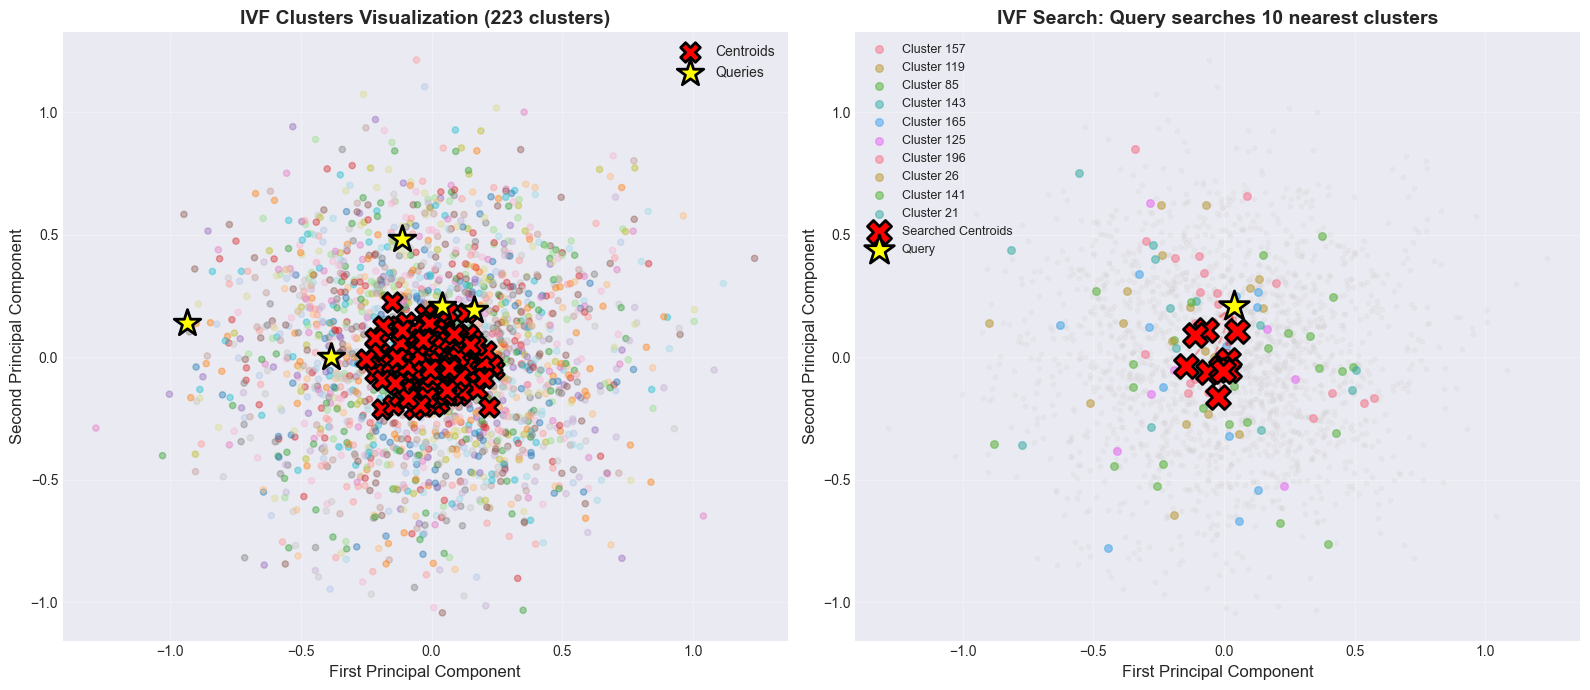

✓ Đã lưu: 02_ivf_clusters_2d.png


In [15]:
# Visualize clusters in 2D
print("Visualization clusters trong 2D...")

# Sample for visualization
n_sample = 2000
sample_idx = np.random.choice(n_vectors, n_sample, replace=False)
sample_vectors = database_vectors[sample_idx]
sample_clusters = cluster_assignments[sample_idx]

# Get centroids from the trained quantizer
# After training IVF, the centroids are stored in the quantizer as vectors
# We can reconstruct them one by one
centroids = np.zeros((nlist, dimension), dtype=np.float32)
for i in range(nlist):
    centroids[i] = index_ivf.quantizer.reconstruct(i)

# PCA projection
print("  Applying PCA...")
pca = PCA(n_components=2)
all_data = np.vstack([sample_vectors, centroids, query_vectors[:5]])
pca.fit(all_data)

sample_2d = pca.transform(sample_vectors)
centroids_2d = pca.transform(centroids)
queries_2d = pca.transform(query_vectors[:5])

print(f"  ✓ PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: All clusters
ax = axes[0]
scatter = ax.scatter(sample_2d[:, 0], sample_2d[:, 1], 
                     c=sample_clusters, cmap='tab20', alpha=0.4, s=20)
ax.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
           c='red', marker='X', s=200, edgecolors='black', 
           linewidth=2, label='Centroids', zorder=5)
ax.scatter(queries_2d[:, 0], queries_2d[:, 1],
           c='yellow', marker='*', s=400, edgecolors='black',
           linewidth=2, label='Queries', zorder=6)
ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title(f'IVF Clusters Visualization ({nlist} clusters)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Query with nearest clusters
ax = axes[1]
query_idx = 0
query_2d = queries_2d[query_idx]

# Find nearest centroids to query
_, nearest_clusters = index_ivf.quantizer.search(query_vectors[query_idx:query_idx+1], nprobe)
nearest_clusters = nearest_clusters[0]

# Plot all vectors in gray
ax.scatter(sample_2d[:, 0], sample_2d[:, 1], 
           c='lightgray', alpha=0.2, s=10)

# Highlight vectors in searched clusters
for cluster_id in nearest_clusters:
    mask = sample_clusters == cluster_id
    if mask.any():
        ax.scatter(sample_2d[mask, 0], sample_2d[mask, 1],
                   alpha=0.5, s=30, label=f'Cluster {cluster_id}')

# Plot nearest centroids
ax.scatter(centroids_2d[nearest_clusters, 0], centroids_2d[nearest_clusters, 1],
           c='red', marker='X', s=300, edgecolors='black',
           linewidth=2, label='Searched Centroids', zorder=5)

# Plot query
ax.scatter(query_2d[0], query_2d[1], c='yellow', marker='*',
           s=500, edgecolors='black', linewidth=2,
           label='Query', zorder=6)

# Draw lines to searched centroids
for cluster_id in nearest_clusters:
    centroid_pos = centroids_2d[cluster_id]
    ax.plot([query_2d[0], centroid_pos[0]], 
            [query_2d[1], centroid_pos[1]],
            'r--', alpha=0.3, linewidth=1.5)

ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title(f'IVF Search: Query searches {nprobe} nearest clusters', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_ivf_clusters_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu: 02_ivf_clusters_2d.png")

## 6. Trade-off: nprobe vs Recall/Speed

In [16]:
# Benchmark different nprobe values
print("Benchmark nprobe values...\n")

nprobe_values = [1, 2, 4, 8, 16, 32, 64, 128]
results = progressive_recall_benchmark(
    index_ivf,
    query_vectors,
    gt_indices,
    'nprobe',
    nprobe_values,
    k
)

# Visualize
plot_recall_vs_time(
    results,
    title='IVF: Trade-off between nprobe and Recall/Speed',
    save_path='02_nprobe_tradeoff.png'
)

print(f"\n✓ Đã lưu: 02_nprobe_tradeoff.png")

Benchmark nprobe values...


Progressive benchmark for nprobe:
Value      Recall@10       QPS             Time (s)       
-------------------------------------------------------
1          0.0420          10676.3         0.0187         
2          0.0755          50354.8         0.0040         
4          0.1290          12947.0         0.0154         
8          0.2020          15488.6         0.0129         
16         0.3160          16849.0         0.0119         
32         0.4670          14512.7         0.0138         
64         0.6835          8775.2          0.0228         
128        0.8955          7071.2          0.0283         
  ✓ Đã lưu biểu đồ vào: 02_nprobe_tradeoff.png

✓ Đã lưu: 02_nprobe_tradeoff.png


## 7. So sánh IVF vs Flat

So sánh IVF (different nprobe) vs Flat...

Flat Index:
  Recall: 100.0%
  QPS: 622.5



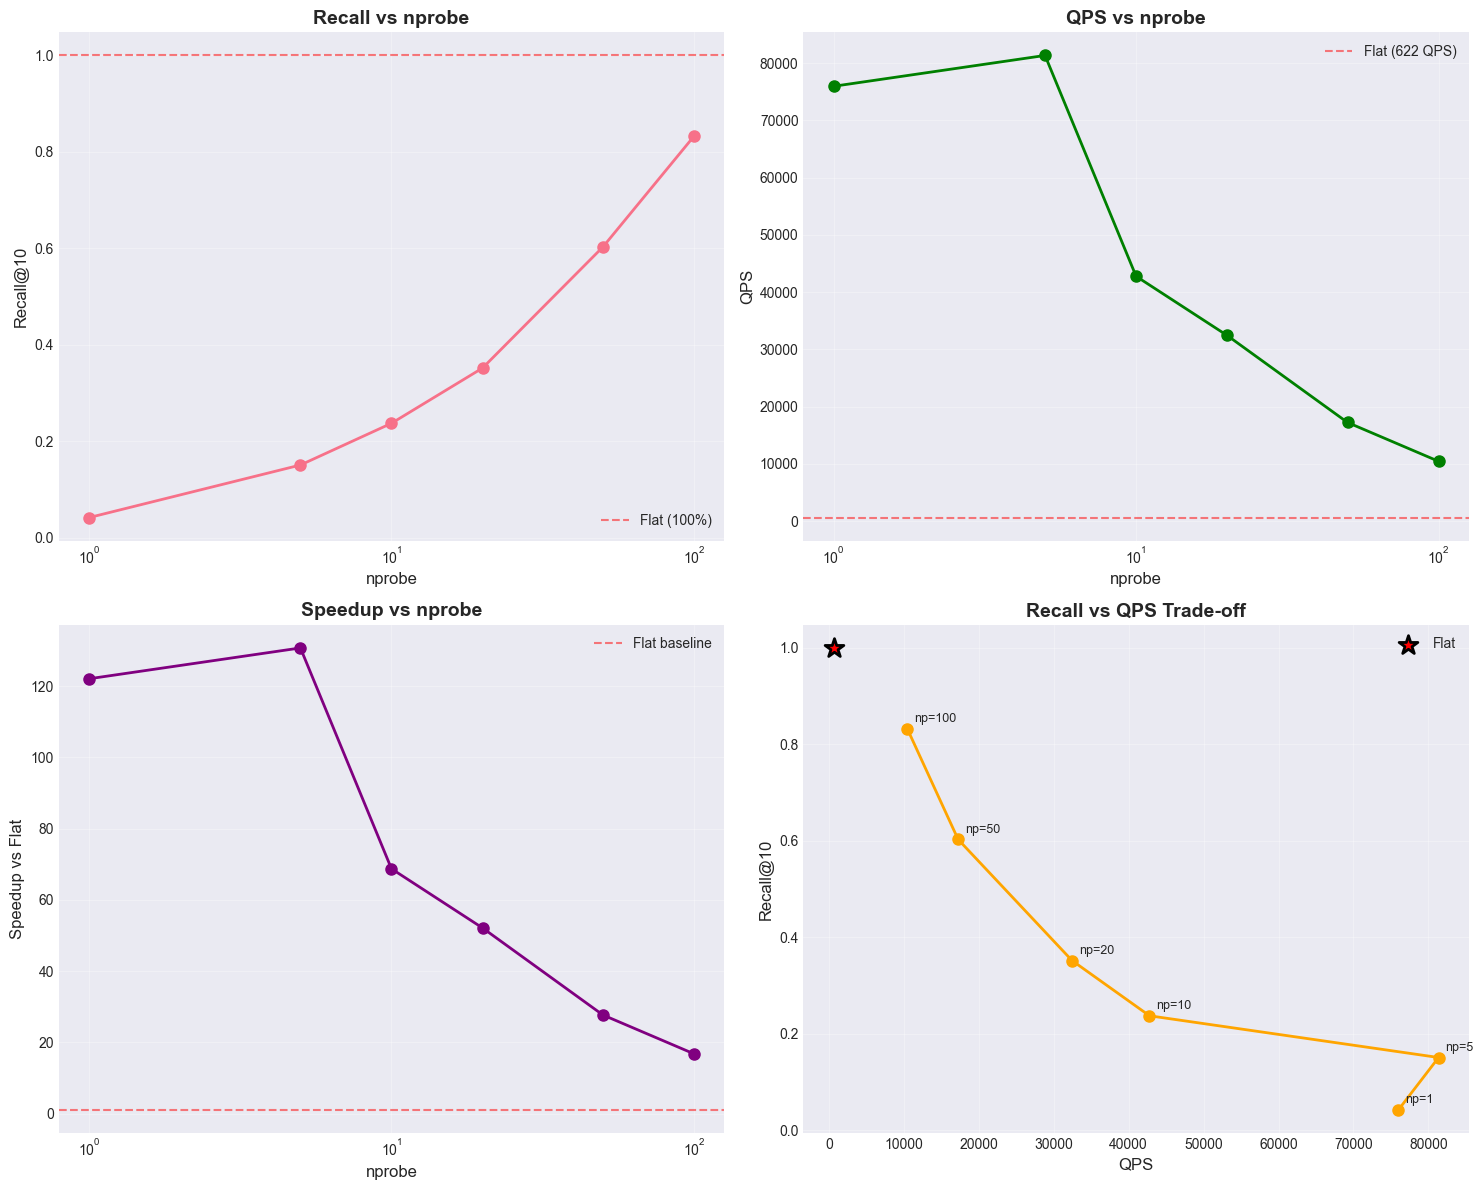

✓ Đã lưu: 02_ivf_vs_flat_comparison.png


In [17]:
# Compare IVF with different nprobe vs Flat
print("So sánh IVF (different nprobe) vs Flat...\n")

comparison_data = {
    'nprobe': [],
    'recall': [],
    'qps': [],
    'search_time': [],
    'speedup': []
}

# Flat baseline
flat_results = benchmark_index(index_flat, query_vectors, k, gt_indices)
flat_qps = flat_results['qps']

print(f"Flat Index:")
print(f"  Recall: 100.0%")
print(f"  QPS: {flat_qps:.1f}")
print()

# IVF with different nprobe
test_nprobe = [1, 5, 10, 20, 50, 100]
for np_val in test_nprobe:
    index_ivf.nprobe = np_val
    ivf_results = benchmark_index(index_ivf, query_vectors, k, gt_indices)
    
    comparison_data['nprobe'].append(np_val)
    comparison_data['recall'].append(ivf_results[f'recall@{k}'])
    comparison_data['qps'].append(ivf_results['qps'])
    comparison_data['search_time'].append(ivf_results['search_time'])
    comparison_data['speedup'].append(ivf_results['qps'] / flat_qps)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Recall vs nprobe
ax = axes[0, 0]
ax.plot(comparison_data['nprobe'], comparison_data['recall'], 
        'o-', linewidth=2, markersize=8)
ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Flat (100%)')
ax.set_xlabel('nprobe', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Recall vs nprobe', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: QPS vs nprobe
ax = axes[0, 1]
ax.plot(comparison_data['nprobe'], comparison_data['qps'],
        'o-', linewidth=2, markersize=8, color='green')
ax.axhline(flat_qps, color='red', linestyle='--', alpha=0.5, 
           label=f'Flat ({flat_qps:.0f} QPS)')
ax.set_xlabel('nprobe', fontsize=12)
ax.set_ylabel('QPS', fontsize=12)
ax.set_title('QPS vs nprobe', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Speedup vs nprobe
ax = axes[1, 0]
ax.plot(comparison_data['nprobe'], comparison_data['speedup'],
        'o-', linewidth=2, markersize=8, color='purple')
ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Flat baseline')
ax.set_xlabel('nprobe', fontsize=12)
ax.set_ylabel('Speedup vs Flat', fontsize=12)
ax.set_title('Speedup vs nprobe', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 4: Recall vs QPS (Pareto frontier)
ax = axes[1, 1]
ax.plot(comparison_data['qps'], comparison_data['recall'],
        'o-', linewidth=2, markersize=8, color='orange')
ax.scatter([flat_qps], [1.0], s=200, c='red', marker='*',
           edgecolors='black', linewidth=2, label='Flat', zorder=5)
for i, np_val in enumerate(comparison_data['nprobe']):
    ax.annotate(f'np={np_val}', 
                (comparison_data['qps'][i], comparison_data['recall'][i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel('QPS', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Recall vs QPS Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('02_ivf_vs_flat_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu: 02_ivf_vs_flat_comparison.png")

## 8. Phân tích Search Coverage

Phân tích search coverage...

nprobe=   1: Searches ~    224 vectors (  0.4%)
nprobe=   5: Searches ~   1121 vectors (  2.2%)
nprobe=  10: Searches ~   2242 vectors (  4.5%)
nprobe=  20: Searches ~   4484 vectors (  9.0%)
nprobe=  50: Searches ~  11211 vectors ( 22.4%)
nprobe= 100: Searches ~  22422 vectors ( 44.8%)
nprobe= 223: Searches ~  50000 vectors (100.0%)


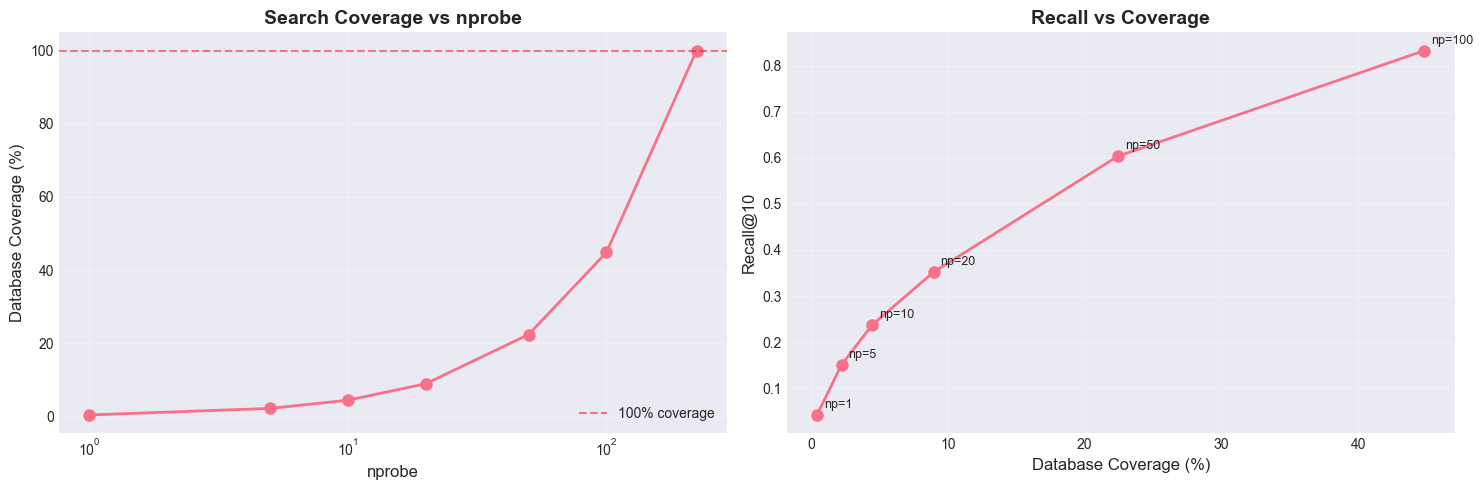


✓ Đã lưu: 02_search_coverage.png


In [18]:
# Analyze what percentage of database is searched with different nprobe
print("Phân tích search coverage...\n")

nprobe_test = [1, 5, 10, 20, 50, 100, nlist]
coverage_data = []

for np_val in nprobe_test:
    # Each cluster has avg cluster_size vectors
    avg_cluster_size = n_vectors / nlist
    searched_vectors = min(np_val * avg_cluster_size, n_vectors)
    coverage = searched_vectors / n_vectors * 100
    coverage_data.append(coverage)
    print(f"nprobe={np_val:>4}: Searches ~{searched_vectors:>7.0f} vectors ({coverage:>5.1f}%)")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Coverage vs nprobe
ax1.plot(nprobe_test, coverage_data, 'o-', linewidth=2, markersize=8)
ax1.axhline(100, color='red', linestyle='--', alpha=0.5, label='100% coverage')
ax1.set_xlabel('nprobe', fontsize=12)
ax1.set_ylabel('Database Coverage (%)', fontsize=12)
ax1.set_title('Search Coverage vs nprobe', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Coverage vs Recall
# Match with recall data from previous benchmark
matching_nprobe = [np_val for np_val in nprobe_test if np_val in comparison_data['nprobe']]
matching_recall = [comparison_data['recall'][comparison_data['nprobe'].index(np_val)] 
                   for np_val in matching_nprobe]
matching_coverage = [coverage_data[nprobe_test.index(np_val)] 
                     for np_val in matching_nprobe]

ax2.plot(matching_coverage, matching_recall, 'o-', linewidth=2, markersize=8)
for i, np_val in enumerate(matching_nprobe):
    ax2.annotate(f'np={np_val}',
                 (matching_coverage[i], matching_recall[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Database Coverage (%)', fontsize=12)
ax2.set_ylabel('Recall@10', fontsize=12)
ax2.set_title('Recall vs Coverage', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_search_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Đã lưu: 02_search_coverage.png")

## 9. Tóm tắt

In [19]:
print("="*70)
print("TÓM TẮT - IVF Index")
print("="*70)

# Find optimal nprobe (best recall/speed trade-off)
# Let's say we want >90% recall
optimal_idx = next((i for i, r in enumerate(comparison_data['recall']) 
                    if r >= 0.9), len(comparison_data['recall'])-1)
optimal_nprobe = comparison_data['nprobe'][optimal_idx]
optimal_recall = comparison_data['recall'][optimal_idx]
optimal_speedup = comparison_data['speedup'][optimal_idx]

print(f"\n✓ IVF Configuration:")
print(f"  nlist: {nlist}")
print(f"  Average cluster size: {n_vectors/nlist:.0f}")

print(f"\n✓ Optimal nprobe (for ~90% recall):")
print(f"  nprobe: {optimal_nprobe}")
print(f"  Recall: {optimal_recall:.1%}")
print(f"  Speedup vs Flat: {optimal_speedup:.1f}x")

print(f"\n✓ Key Insights:")
print(f"  - IVF chia database thành {nlist} clusters")
print(f"  - Search chỉ trong nprobe clusters gần nhất")
print(f"  - Trade-off: nprobe cao = recall cao, speed thấp")
print(f"  - Có thể tune nprobe runtime (không cần rebuild)")

print(f"\n✓ Best Practices:")
print(f"  - nlist ≈ sqrt(n) hoặc 4*sqrt(n)")
print(f"  - Train với ≥30*nlist vectors")
print(f"  - Start với nprobe=10, tune theo requirement")
print(f"  - Kết hợp với PQ để giảm memory")

print(f"\n" + "="*70)

TÓM TẮT - IVF Index

✓ IVF Configuration:
  nlist: 223
  Average cluster size: 224

✓ Optimal nprobe (for ~90% recall):
  nprobe: 100
  Recall: 83.3%
  Speedup vs Flat: 16.8x

✓ Key Insights:
  - IVF chia database thành 223 clusters
  - Search chỉ trong nprobe clusters gần nhất
  - Trade-off: nprobe cao = recall cao, speed thấp
  - Có thể tune nprobe runtime (không cần rebuild)

✓ Best Practices:
  - nlist ≈ sqrt(n) hoặc 4*sqrt(n)
  - Train với ≥30*nlist vectors
  - Start với nprobe=10, tune theo requirement
  - Kết hợp với PQ để giảm memory

